On this starter notebook, we aim to:

* Prepare the data for instance segmentation (convert to COCO format)
* Visualize the data (image and processing)

COCO format example:

* https://www.kaggle.com/mlwhiz/simpsons-main-characters
* https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch
* https://www.kaggle.com/fmscole/convert-dataset-to-coco-format-tools

Others:

* https://towardsdatascience.com/self-supervised-keypoint-learning-aade18081fc3
* https://github.com/qubvel/ttach
* https://debuggercafe.com/human-pose-detection-using-pytorch-keypoint-rcnn/
* https://stackoverflow.com/questions/62899503/how-to-train-a-custom-keypoint-detector-for-drone-pose-estimation-detectron2

Insights:

* 6 images with multiple astronauts
* 68 polygons are single (~73%)
    

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd 
import numpy as np 
import glob
import json
import ast
from PIL import Image
from imantics import Annotation

In [3]:
IMAGE_TRAIN_PATH = "data/raw/train/images/"

In [4]:
def generate_image_metadata(dirname):
    """
    Extract the width and height
    """
    file_list = []
    width_list = []
    height_list = []
    for filename in glob.glob(dirname + '*.*'):
        img = Image.open(filename)
        width, height = img.size
        file_list.append(os.path.basename(filename))
        width_list.append(width)
        height_list.append(height)
    
    res = pd.DataFrame({"filename": file_list, "width": width_list, "height":height_list})
    return res

def get_pose(x, level=1):
    x = x.split(",")
    if level == 1:
        x = x[0:45]
    elif level == 2:
        x = x[45:90]
    x = ','.join(x)
    return x

## Data Preparation

In [5]:
df_metadata = generate_image_metadata(IMAGE_TRAIN_PATH)
df_metadata["id"] = df_metadata["filename"].str.replace(".png|.jpg", "").astype(int)

In [6]:
with open(IMAGE_TRAIN_PATH + "annotations/truth2d.txt") as f:
    labels = f.read().splitlines()

In [7]:
file_list = []
pose_list = []
polygon_list = []
for label in labels:
    # Split polygon
    data = label.split("[")
    file_pose = data[0].split(",")

    if len(data) > 1:
        for polygon in data[1:]:
            file_list.append(file_pose[0])
            pose_list.append(",".join(file_pose[1:]))
            polygon_list.append(polygon.replace("]", ""))
    else:
        file_list.append(file_pose[0])
        pose_list.append(np.NaN)
        polygon_list.append(np.NaN)

In [8]:
df_label = pd.DataFrame({"filename": file_list, "pose": pose_list, "polygon": polygon_list})
df_label["polygon_cnt"] = df_label.polygon.str.count("\\)\\(") + 1
df_label["polygon_cnt"] = df_label["polygon_cnt"].fillna(0)
df_label["pose_cnt"] = (df_label.pose.str.count(",")) * 2/3 / 2
df_label["pose_cnt"] = df_label["pose_cnt"].fillna(0)
df_label

,filename,pose,polygon,polygon_cnt,pose_cnt
0,952799.jpg,NaN,NaN,0.0,0.0
1,626913.jpg,NaN,NaN,0.0,0.0
2,204037.jpg,NaN,NaN,0.0,0.0
3,771734.jpg,"238.0,191.0,2,428.0,207.0,2,334.0,291.0,2,237....","(242.8,130.0,264.0,111.8,268.5,111.8,271.5,107...",2.0,15.0
4,895632.jpg,"819.0,362.0,2,795.0,456.0,2,744.0,412.0,2,732....","(226.1,267.0,229.2,258.5,236.6,254.3,266.0,254...",1.0,15.0
...,...,...,...,...,...
87,140435.png,"515.0,199.0,2,604.0,185.0,2,556.0,263.0,2,0.0,...","(498.9,131.5,500.2,127.7,507.8,120.1,530.6,106...",1.0,30.0
88,140435.png,"515.0,199.0,2,604.0,185.0,2,556.0,263.0,2,0.0,...","(41.7,96.0,253.2,93.5,289.9,185.9,292.5,185.9,...",1.0,30.0
89,948061.png,"492.0,316.0,2,674.0,315.0,2,584.0,418.0,2,389....","(271.3,145.4,272.6,140.4,281.4,132.8,293.9,122...",1.0,15.0
90,949796.png,"0.0,0.0,0,416.0,268.0,1,383.0,341.0,2,0.0,0.0,...","(378.4,200.4,390.6,198.0,407.7,198.0,412.5,200...",1.0,15.0


In [9]:
df_label.filename.value_counts().reset_index().filename.value_counts()

1    80
2     6
Name: filename, dtype: int64

In [10]:
df_label.polygon_cnt.value_counts()

1.0     68
2.0      9
3.0      6
4.0      4
0.0      3
5.0      1
11.0     1
Name: polygon_cnt, dtype: int64

In [11]:
df_label.pose_cnt.value_counts()

15.0    77
30.0    12
0.0      3
Name: pose_cnt, dtype: int64

Fix `pose_cnt` > 15

In [12]:
df_label['r'] = df_label.groupby(['filename']).cumcount()+1
for i, r in df_label[df_label['pose_cnt'] > 0].iterrows():
    res = get_pose(r['pose'], r['r'])
    df_label.loc[i, 'pose'] = res


In [13]:
df_label["pose_cnt"] = (df_label.pose.str.count(",") + 1) * 2/3 / 2
df_label["pose_cnt"] = df_label["pose_cnt"].fillna(0)
df_label.pose_cnt.value_counts()

15.0    89
0.0      3
Name: pose_cnt, dtype: int64

In [14]:
df_label.loc[df_label["polygon_cnt"] > 0, "is_crowd"] = \
    np.where(df_label.loc[df_label["polygon_cnt"] > 0, "polygon_cnt"] > 1, 0, 0)

In [15]:
df_label["image_id"] = df_label["filename"].str.replace(".png|.jpg", "").astype(int)
df_label = df_label.reset_index()

In [16]:
df_label

,index,filename,pose,polygon,polygon_cnt,pose_cnt,r,is_crowd,image_id
0,0,952799.jpg,NaN,NaN,0.0,0.0,1,NaN,952799
1,1,626913.jpg,NaN,NaN,0.0,0.0,1,NaN,626913
2,2,204037.jpg,NaN,NaN,0.0,0.0,1,NaN,204037
3,3,771734.jpg,"238.0,191.0,2,428.0,207.0,2,334.0,291.0,2,237....","(242.8,130.0,264.0,111.8,268.5,111.8,271.5,107...",2.0,15.0,1,0.0,771734
4,4,895632.jpg,"819.0,362.0,2,795.0,456.0,2,744.0,412.0,2,732....","(226.1,267.0,229.2,258.5,236.6,254.3,266.0,254...",1.0,15.0,1,0.0,895632
...,...,...,...,...,...,...,...,...,...
87,87,140435.png,"515.0,199.0,2,604.0,185.0,2,556.0,263.0,2,0.0,...","(498.9,131.5,500.2,127.7,507.8,120.1,530.6,106...",1.0,15.0,1,0.0,140435
88,88,140435.png,"0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,277.0,287.0,2,38...","(41.7,96.0,253.2,93.5,289.9,185.9,292.5,185.9,...",1.0,15.0,2,0.0,140435
89,89,948061.png,"492.0,316.0,2,674.0,315.0,2,584.0,418.0,2,389....","(271.3,145.4,272.6,140.4,281.4,132.8,293.9,122...",1.0,15.0,1,0.0,948061
90,90,949796.png,"0.0,0.0,0,416.0,268.0,1,383.0,341.0,2,0.0,0.0,...","(378.4,200.4,390.6,198.0,407.7,198.0,412.5,200...",1.0,15.0,1,0.0,949796


### Convert to COCO format

Images required these values:

* file_name
* height, width
* id

Annotation consists of:

* segmentation
* num_keypoints
* area
* is_crowd
* keypoints
* image_id
* bbox
* category_id
* id

In [17]:
with open("data/cfg/cfg_2d_v1.json") as f:
    cfg = json.load(f)

In [18]:
for idx, row in df_metadata.iterrows():
    cfg["images"].append(
        {
            "file_name": row["filename"],
            "height": row["height"],
            "width": row["width"],
            "id": row["id"]
        }
    )

In [19]:
for idx, row in df_label[~df_label["pose"].isnull()].iterrows():
    img = Image.open("data/raw/train/images/" + row["filename"])
    seg = json.loads("[" + row["polygon"].replace("(", "[").replace(")", "]").replace("][", "],[") + "]")
    ann = Annotation(polygons=seg, image=img)
    kpt = json.loads("[" + row["pose"] + "]")

    cfg["annotations"].append(
        {
            "segmentation": seg,
            "num_keypoints": 15,
            "area": ann.area,
            "iscrowd": row["is_crowd"],
            "keypoints": kpt,
            "image_id": row["image_id"],
            "bbox": list(ann.bbox),
            "category_id": 1,
            "id": row["index"]
        }
    )

In [20]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [21]:
with open("data/annotation_2d.json", "w") as f:
    json.dump(cfg, f, cls=NpEncoder, indent=4)

## Test Imantics

In [159]:
sample = df_label[~df_label["pose"].isnull()].iloc[0,:]
sample

index                                                          3
filename                                              771734.jpg
pose           238.0,191.0,2,428.0,207.0,2,334.0,291.0,2,237....
polygon        (242.8,130.0,264.0,111.8,268.5,111.8,271.5,107...
polygon_cnt                                                    2
pose_cnt                                                      15
r                                                              1
is_crowd                                                       0
image_id                                                  771734
Name: 3, dtype: object

In [160]:
img = Image.open("data/raw/train/images/" + '771734.jpg')
poly_txt = "[" + sample["polygon"].replace("(", "[").replace(")", "]").replace("][", "],[") + "]"
seg = json.loads(poly_txt)
ann = Annotation(polygons=seg, image=img)
kpt = json.loads("[" + sample["pose"] + "]")

In [161]:
list(ann.bbox)

[116, 88, 529, 1046]

In [162]:
ann.bbox.bbox

<bound method BBox.bbox of (116, 88, 529, 1046)>

In [163]:
ann.width

640

In [164]:
ann.height

1093

In [122]:
ann.area

123899

## EDA

Tutorial: https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047

In [22]:
from pycocotools.coco import COCO
import skimage.io as io
import random
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [200]:
coco = COCO("data/annotation_2d.json")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [24]:
catIds = coco.getCatIds()
cats = coco.loadCats(catIds)
imgIds = coco.getImgIds(catIds=catIds)

In [183]:
np.random.seed(1000)
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

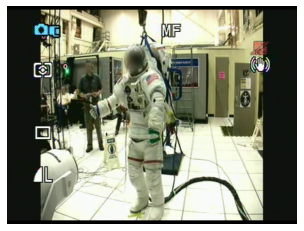

In [184]:
I = io.imread("data/raw/train/images/" + img["file_name"])/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

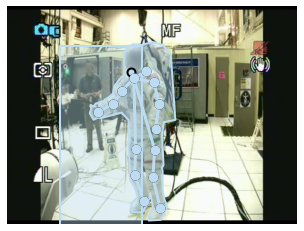

In [190]:
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

In [195]:
anns[0]['bbox']

[116, 88, 297, 870]

In [198]:
annIds

[3]

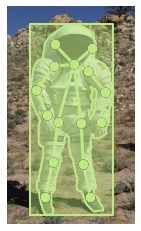

In [202]:
img = coco.loadImgs(771734)[0]
I = io.imread("data/raw/train/images/" + img["file_name"])/255.0
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
# [116, 88, 529, 1046]
# anns[0]['bbox'] = [116, 88, 529-116, 1046-88]
anns[0]['bbox'] = [anns[0]['bbox'][0], anns[0]['bbox'][1], anns[0]['bbox'][2]-anns[0]['bbox'][0], anns[0]['bbox'][3]-anns[0]['bbox'][1]]
coco.showAnns(anns, draw_bbox=True)

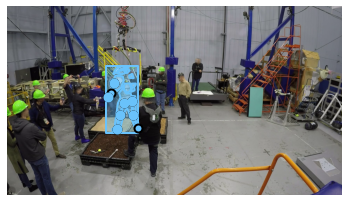

In [203]:
img = coco.loadImgs(965295)[0]
I = io.imread("data/raw/train/images/" + img["file_name"])/255.0
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
anns[0]['bbox'] = [anns[0]['bbox'][0], anns[0]['bbox'][1], anns[0]['bbox'][2]-anns[0]['bbox'][0], anns[0]['bbox'][3]-anns[0]['bbox'][1]]
coco.showAnns(anns, draw_bbox=True)

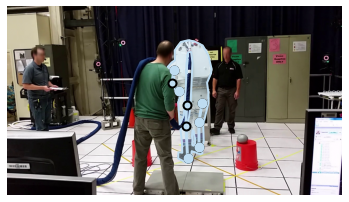

In [30]:
img = coco.loadImgs(969689)[0]
I = io.imread("data/raw/train/images/" + img["file_name"])/255.0
plt.imshow(I)
plt.axis('off') 
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [31]:
df_label.sort_values("polygon_cnt", ascending=False)

,index,filename,pose,polygon,polygon_cnt,pose_cnt,r,is_crowd,image_id
33,33,965295.png,"0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0....","(592.0,430.4,596.3,422.4,620.1,409.4,615.1,401...",11.0,15.0,1,0.0,965295
51,51,969689.png,"0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0....","(689.9,181.4,687.9,210.1,687.9,200.8,684.9,219...",5.0,15.0,1,0.0,969689
29,29,950880.png,"840.0,461.0,1,830.0,476.0,2,824.0,515.0,1,867....","(775.9,673.2,723.5,683.7,708.6,661.2,722.0,632...",4.0,15.0,1,0.0,950880
30,30,528003.png,"860.0,456.0,1,846.0,473.0,1,849.0,513.0,1,897....","(828.3,415.8,831.3,652.3,805.8,677.7,752.0,703...",4.0,15.0,1,0.0,528003
27,27,873425.jpg,"1844.0,372.0,2,2031.0,379.0,1,1973.0,479.0,2,1...","(1668.1,719.0,1670.3,706.8,1675.3,694.3,1672.5...",4.0,15.0,2,0.0,873425
...,...,...,...,...,...,...,...,...,...
26,26,873425.jpg,"1179.0,370.0,2,1421.0,397.0,1,1343.0,514.0,2,1...","(1263.3,1579.6,1263.3,1581.8,1265.6,1581.8,126...",1.0,15.0,1,0.0,873425
25,25,351722.jpg,"277.0,148.0,2,380.0,133.0,2,298.0,231.0,2,262....","(232.2,172.5,222.7,107.0,239.0,67.3,233.6,40.0...",1.0,15.0,1,0.0,351722
1,1,626913.jpg,NaN,NaN,0.0,0.0,1,NaN,626913
2,2,204037.jpg,NaN,NaN,0.0,0.0,1,NaN,204037
